<a href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/content/bert_sentiment_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 George Mihaila.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GPUs in Natural Language Processing


<td>
    <a target="_blank" href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/content/bert_sentiment_clustering.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/gtc2020_instructor_training.git"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Dataset used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.


### Content:

 * Use Sentence Embeddings from pretrained state of the art language models, in this case **bert-base-nli-stsb-mean-tokens**, to transform text data data into fixed vector feratures of length **768 features**. Performing model inference using GPU.
 * Train small Neural Network and interpret model.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.

## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Notebook Environment Sanity Check

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4 or P100.

[source](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD)

In [13]:
## VERSION CHECK
!nvidia-smi
!nvcc -V
!python -V; pip -V

Fri Feb 14 08:09:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W / 250W |  12865MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

* Set up script installs for [Rapids](https://rapids.ai):

  1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
  1. removes incompatible files
  1. Install RAPIDS libraries
  1. Set necessary environment variables
  1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
  1. Recommend select v0.10.

In [2]:
import sys, os
from IPython.display import clear_output

# Install RAPIDS
!rm rapids-colab.sh
!wget -nc https://raw.githubusercontent.com/rapidsai/notebooks-contrib/890b04ed8687da6e3a100c81f449ff6f7b559956/utils/rapids-colab.sh
!bash rapids-colab.sh

dist_package_index = sys.path.index("/usr/local/lib/python3.6/dist-packages")
sys.path = sys.path[:dist_package_index] + ["/usr/local/lib/python3.6/site-packages"] + sys.path[dist_package_index:]
sys.path
if os.path.exists('update_pyarrow.py'): ## This file only exists if you're using RAPIDS version 0.11 or higher
  exec(open("update_pyarrow.py").read(), globals())
clear_output(wait=True)

rm: cannot remove 'rapids-colab.sh': No such file or directory
--2020-02-14 07:50:40--  https://raw.githubusercontent.com/rapidsai/notebooks-contrib/890b04ed8687da6e3a100c81f449ff6f7b559956/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5286 (5.2K) [text/plain]
Saving to: ‘rapids-colab.sh’

rapids-colab.sh     100%[===================>]   5.16K  --.-KB/s    in 0s      

2020-02-14 07:50:40 (88.9 MB/s) - ‘rapids-colab.sh’ saved [5286/5286]

PLEASE READ
********************************************************************************************************
Colab v0.11+ Migration Notice:
 
There has been a NECESSARY Colab script code change for VERSION 0.11+ that MAY REQUIRE an update how you install RAPIDS into Colab!  
Not all Colab notebook

In [3]:
!pip uninstall cffi -y
!sudo apt-get install python-cffi
clear_output(wait=True)

Found existing installation: cffi 1.13.2
Uninstalling cffi-1.13.2:
  Successfully uninstalled cffi-1.13.2
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  python-cffi-backend python-ply python-pycparser
Suggested packages:
  python-ply-doc python-pkg-resources
The following NEW packages will be installed:
  python-cffi python-cffi-backend python-ply python-pycparser
0 upgraded, 4 newly installed, 0 to remove and 25 not upgraded.
Need to get 245 kB of archives.
After this operation, 1,349 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-cffi-backend amd64 1.11.5-1 [63.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-ply all 3.11-1 [46.6 kB]
Get:3 http://archive.ubuntu.com/

In [4]:
# install sentence transfomers
!pip install git+https://github.com/arvkevi/kneed # for graph knee detection
!pip install git+https://github.com/UKPLab/sentence-transformers
!pip install lime

clear_output(wait=True)

  Cloning https://github.com/arvkevi/kneed to /tmp/pip-req-build-h7mtq5b8
  Running command git clone -q https://github.com/arvkevi/kneed /tmp/pip-req-build-h7mtq5b8
     |████████████████████████████████| 13.1 MB 8.7 MB/s 
     |████████████████████████████████| 7.0 MB 100.3 MB/s 
     |████████████████████████████████| 26.1 MB 18 kB/s 
     |████████████████████████████████| 90 kB 13.3 MB/s 
     |████████████████████████████████| 67 kB 7.9 MB/s 
     |████████████████████████████████| 294 kB 86.1 MB/s 
  Created wheel for kneed: filename=kneed-0.5.3-py2.py3-none-any.whl size=10206 sha256=a301bdcbe2ce102dedc559e8ae1b242f5985df6a5a1a1016a52d7c56249b4f64
  Stored in directory: /tmp/pip-ephem-wheel-cache-qbarbuxv/wheels/34/1e/5b/8fccab4811880902601d6770c8af716cde606d78a033ac84fb
Successfully built kneed


  Cloning https://github.com/UKPLab/sentence-transformers to /tmp/pip-req-build-oea48dfc
  Running command git clone -q https://github.com/UKPLab/sentence-transformers /tmp/pip-req-build-oea48dfc
     |████████████████████████████████| 447 kB 8.9 MB/s 
     |████████████████████████████████| 59 kB 7.1 MB/s 
     |████████████████████████████████| 753.4 MB 21 kB/s 
     |████████████████████████████████| 1.5 MB 55.9 MB/s 
     |████████████████████████████████| 1.0 MB 40.4 MB/s 
     |████████████████████████████████| 128 kB 103.7 MB/s 
     |████████████████████████████████| 860 kB 73.8 MB/s 
     |████████████████████████████████| 689 kB 61.1 MB/s 
     |████████████████████████████████| 69 kB 10.5 MB/s 
     |████████████████████████████████| 5.9 MB 63.1 MB/s 
     |████████████████████████████████| 81 kB 11.9 MB/s 
     |████████████████████████████████| 547 kB 99.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.5-py3-none-any.whl size=69891 sha2

### Downloads

In [5]:
if not os.path.exists('imdb_reviews_all_labeled.csv'):
  # IMDB movie reviews
  !wget https://github.com/gmihaila/gtc2020_instructor_training/raw/master/data/imdb_reviews_all_labeled.csv

--2020-02-14 08:00:06--  https://github.com/gmihaila/gtc2020_instructor_training/raw/master/data/imdb_reviews_all_labeled.csv
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gmihaila/gtc2020_instructor_training/master/data/imdb_reviews_all_labeled.csv [following]
--2020-02-14 08:00:07--  https://raw.githubusercontent.com/gmihaila/gtc2020_instructor_training/master/data/imdb_reviews_all_labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65862311 (63M) [text/plain]
Saving to: ‘imdb_reviews_all_labeled.csv’

imdb_reviews_all_la 100%[===================>]  62.81M   211MB/s    in 0.3s    

2020-0

### Imports

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer
import cudf
from cuml import KMeans
from cuml import PCA as cuPCA
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from lime.lime_text import LimeTextExplainer


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

os.environ['NUMBAPRO_NVVM']='/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so'  
os.environ['NUMBAPRO_LIBDEVICE']='/usr/local/cuda-10.0/nvvm/libdevice'

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

TensorFlow 2.x selected.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Functions

In [0]:
def read_yelp_reviews(filename):
  tmp_df = pd.read_pickle(filename)
  yelp_reviews_texts = tmp_df['text'].values
  yelp_reviews_stars = tmp_df['stars'].values
  return yelp_reviews_texts, yelp_reviews_stars


def context_embedding(text, name_of_model, batch_size=1000, use_device="cuda"):
  embed_model = SentenceTransformer(model_name_or_path=name_of_model,
                                    device=torch.device(use_device))
  encodings_text = embed_model.encode(sentences=text, 
                                          batch_size=batch_size, 
                                          show_progress_bar=True)
  # empty GPU cache
  torch.cuda.empty_cache()
  return  np.array(encodings_text)


def best_kmeans_elbow(features, n_clusters, verbose=False, show=False):
  features = cudf.DataFrame.from_gpu_matrix(features)
  # features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  distortions = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(features)
    
    distortion = kmean_model.inertia_
    distortions.append(distortion)

    if verbose: print("For n_clusters =", n_clusters, "Distortion is :", distortion)

  kn = KneeLocator(clusters, distortions, curve='convex', direction='decreasing')
  best_k = int(kn.knee)

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      distortions,
                      color="coral", 
                      label="Distortions")
  plot.set(xlabel='k', ylabel='Distortions')
  plot.set_title('Using Elbow method for best k')
  plot.axvline(x=best_k)
  if show: plt.show()
  fig = plot.get_figure()
  fig.savefig("elbow_distortions.png")
  return



def best_kmeans_silhouette(features, n_clusters):
  features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  silhouettes = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(np.array(features))

    cluster_labels = kmean_model.predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

  best_k = clusters[silhouettes.index(max(silhouettes))]

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      silhouettes,
                      color="coral", 
                      label="Silhouette Average Score")
  plot.set(xlabel='k', ylabel='Silhouette Average Score')
  plot.set_title('Silhouette Average Score for each cluster k')
  plot.axvline(x=best_k)
  fig = plot.get_figure()
  fig.savefig("silhouette_avg.png")
  return


def kmeans(k, features):
  features = cudf.DataFrame.from_gpu_matrix(features)
  kmean_model = KMeans(n_clusters=k)
  kmean_model.fit(features)
  labels = kmean_model.labels_
  return labels, kmean_model



def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  # move to GPU matrix
  features = cudf.DataFrame.from_gpu_matrix(features)
  pca_cuml = cuPCA(n_components=n_components,
                   random_state=random_state)
  # pca_cuml.fit(features)
  # reduced_features = pca_cuml.transform(gdf_float)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features.values[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features.values[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
    cluster_plot.savefig("pca_plot.png")
  return reduced_features.values


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

def custom_sample(text, model, prediction_id_label):
  text_embedding = context_embedding(text=[text], 
                                      name_of_model=PRETRAINED_MODEL, 
                                      batch_size=1, use_device="cuda")
  prediction_label = model.predict(np.array(text_embedding))
  return prediction_id_label[prediction_label[0]]

def read_news_data(filename, verbose=False):
  news_contents = []
  with gzip.open(filename, "rb") as f:
    for index, line in enumerate(f, start=1):
      entry = json.loads(line.decode())      
      news_contents.append(entry['content'])
      if (index%50000==0) and verbose:
        print(index)
  return news_contents


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return

def pad_generator(data_generator, max_len=500, valid_split=False, test=0.3):
  data = []
  labels = []
  [(data.append(val), labels.append(label)) for val, label in data_generator]
  if max_len == -1:
    max_len = max([len(instance) for instance in data])
  data = tf.keras.preprocessing.sequence.pad_sequences(sequences=data, 
                                                       maxlen=max_len, 
                                                       dtype='int64', 
                                                       padding='post', 
                                                       truncating='post', 
                                                       value=0)
  labels = np.array(labels, dtype='int64')
  print(data.shape, labels.shape)
  if valid_split:
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test)
    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    return train, test
  else:
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return dataset


def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return

# Dataset

In [8]:
movies_sentiments_df = pd.read_csv('imdb_reviews_all_labeled.csv')

movies_reviews = movies_sentiments_df['reviews'].values
sentiments_reviews = movies_sentiments_df['sentiments'].values

print(movies_reviews[:2])
print(sentiments_reviews[:2])
print(len(sentiments_reviews))

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was

# BERT Embeddings

In [9]:
movies_reviews_embeddings = context_embedding(text=movies_reviews, name_of_model=PRETRAINED_MODEL, batch_size=500, use_device="cuda")

100%|██████████| 405M/405M [00:16<00:00, 25.0MB/s]
Batches: 100%|██████████| 100/100 [06:33<00:00,  8.78s/it]


## Prep Data

In [10]:
EMBEDDING_SIZE = 768
BUFFER_SIZE = 1000
BATCH = 1000
EPOCHS = 20
MAX_LEN = 768

X_train, X_test, y_train, y_test = train_test_split(movies_reviews_embeddings, sentiments_reviews, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# batch padding
train_batches = (train_data.shuffle(BUFFER_SIZE).batch(BATCH))
valid_batches = (valid_data.shuffle(BUFFER_SIZE).batch(BATCH))
test_batches = (test_data.shuffle(BUFFER_SIZE).batch(BATCH))

# sample
encodings, labels = next(iter(train_batches))

print("Text:                  {}".format(movies_reviews[0]))
print("Encoding sample:       {}".format(encodings[0][:5]))
print("Label:                 {}".format(labels[0]))
print("Encoding batch shape:  {}".format(encodings.shape))
print("Labels batch shape:    {}".format(labels.shape))

Text:                  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Encoding sample:       [ 0.1759089   0.46015373  0.1667215   0.40014687 -0.21488261]
Label:                 1
Encoding batch shape:  (1000, 768)
Labels batch shape:    (1000,)


## Simple Neural Network

Epoch: 1/20 loss: 0.5123 acc: 0.6986 val_loss: 0.4436 val_acc: 0.7547	Time epoch: 0.79 batch: 0.02
Epoch: 2/20 loss: 0.4353 acc: 0.7681 val_loss: 0.4231 val_acc: 0.7772	Time epoch: 0.06 batch: 0.00
Epoch: 3/20 loss: 0.4205 acc: 0.7825 val_loss: 0.4128 val_acc: 0.7870	Time epoch: 0.06 batch: 0.00
Epoch: 4/20 loss: 0.4101 acc: 0.7902 val_loss: 0.4050 val_acc: 0.7931	Time epoch: 0.06 batch: 0.00
Epoch: 5/20 loss: 0.4018 acc: 0.7956 val_loss: 0.4016 val_acc: 0.7977	Time epoch: 0.06 batch: 0.00
Epoch: 6/20 loss: 0.3960 acc: 0.7996 val_loss: 0.3969 val_acc: 0.8014	Time epoch: 0.06 batch: 0.00
Epoch: 7/20 loss: 0.3892 acc: 0.8029 val_loss: 0.3923 val_acc: 0.8043	Time epoch: 0.07 batch: 0.00
Epoch: 8/20 loss: 0.3842 acc: 0.8057 val_loss: 0.3895 val_acc: 0.8070	Time epoch: 0.06 batch: 0.00
Epoch: 9/20 loss: 0.3791 acc: 0.8082 val_loss: 0.3863 val_acc: 0.8094	Time epoch: 0.06 batch: 0.00
Epoch: 10/20 loss: 0.3751 acc: 0.8105 val_loss: 0.3852 val_acc: 0.8115	Time epoch: 0.06 batch: 0.00
Epoch: 11

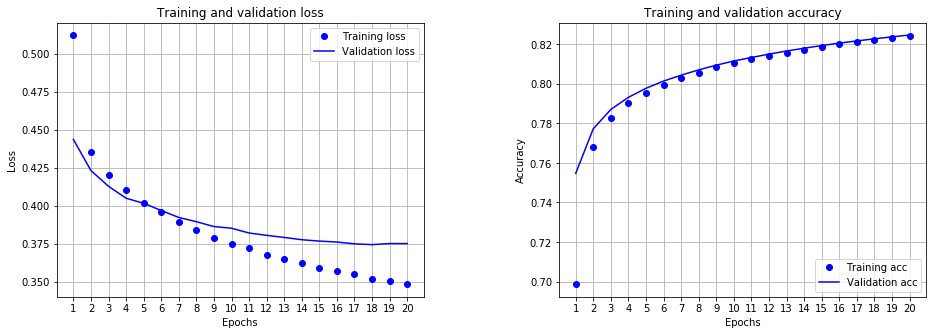

              precision    recall  f1-score   support

    Negative       0.86      0.80      0.83      4997
    Positive       0.81      0.87      0.84      5003

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



In [11]:
class Prediction(tf.keras.Model):
  def __init__(self):
    super(Prediction, self).__init__()
    self.l1 = tf.keras.layers.Dense(units=16, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    return

  def call(self, input_batch):
    intermediate_value = self.l1(input_batch)
    output_batch = self.l2(intermediate_value)
    return output_batch


def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)


@tf.function
def train_batch(input_batch, labels_batch):
  # use global scope variables
  global model_embed, model_dens, model_optimizer
  with tf.GradientTape() as tape:
    preds_batch = model_dens(input_batch)

    loss = loss_func(labels_batch, preds_batch)
    acc = model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

  variables = model_dens.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss, acc



def model_predicitons(data_generator):
  """Predict on test data.
  Make sure train_generator is already batched formatted.
  """
  # models used
  global model
  y_pred = []
  y_true = []
  # make predicitons
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
    preds_batch = model_dens(inputs_batch)

    preds_batch = tf.keras.backend.round(preds_batch)
    [y_pred.append(val[0]) for val in preds_batch]
    [y_true.append(val) for val in labels_batch]
  return np.array(y_true), np.array(y_pred)

def classifier_dn(strings):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  encodings = context_embedding(text=strings, 
                                 name_of_model=PRETRAINED_MODEL, 
                                 batch_size=len(strings), use_device="cuda")
  preds = tf.get_static_value(model_dens(encodings))
  [probab.append([(1-pred[0]), pred[0]]) for pred in preds]
  torch.cuda.empty_cache()
  return np.array(probab)

EPOCHS = 20
history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}



model_dens = Prediction()
model_optimizer = tf.optimizers.Adam()
model_metrics = tf.metrics.Accuracy()

for epoch in range(EPOCHS):
  epoch_time = 0

  # train data
  loss_epoch = 0
  acc_epoch = 0

  for batch, (encodings_batch, labels_batch) in enumerate(train_batches, start=1):
    start_time = time.time()
    # train on batch
    loss_batch, acc_batch = train_batch(encodings_batch, labels_batch)
    # keep track of loss and accuracy
    loss_epoch += loss_batch
    acc_epoch += acc_batch
    end_time = time.time()
    epoch_time += (end_time - start_time)
      
  batch_time = epoch_time / batch
  loss_epoch = tf.get_static_value(loss_epoch) / batch
  history_dict['loss'].append(loss_epoch)
  acc_epoch = tf.get_static_value(acc_epoch) / batch
  history_dict['accuracy'].append(acc_epoch)

  # validation data
  val_acc_epoch = 0
  val_loss_epoch = 0

  for batch, (encodings_bacth, labels_batch) in enumerate(valid_batches, start=1):
    preds_batch = model_dens(encodings_bacth)

    val_loss_epoch += loss_func(labels_batch, preds_batch)
    val_acc_epoch += model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

  val_loss_epoch = tf.get_static_value(val_loss_epoch) / batch
  history_dict['val_loss'].append(val_loss_epoch)

  val_acc_epoch = tf.get_static_value(val_acc_epoch) / batch
  history_dict['val_accuracy'].append(val_acc_epoch)

  print('Epoch: %s/%s loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f\tTime epoch: %.2f batch: %.2f'%(epoch+1, 
                                                                                                      EPOCHS, 
                                                                                                      loss_epoch, 
                                                                                                      acc_epoch, 
                                                                                                      val_loss_epoch, 
                                                                                                      val_acc_epoch,
                                                                                                      epoch_time,
                                                                                                      batch_time))    
plt_history(history_dict)

# evaluate
y_true, y_pred = model_predicitons(test_data.batch(5000))
print(classification_report(y_true, y_pred, target_names=list(ID_SENTIMENT.values())))

## Visualize

In [0]:
# index = np.random.randint(0, 49999)

# text_review = movies_reviews[index]
# sentiment = sentiments_reviews[index]
# print('Review Sample:\n',text_review)
# print('Sentiment: {}\n'.format(ID_SENTIMENT[sentiment]))

# explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
# exp = explainer.explain_instance(text_review,  classifier_dn, num_features=MAX_LEN)
# exp.show_in_notebook(text=True)

# Kmeans Clustering

## Find Best k-means

In [0]:
max_n_cluster = 10

### Elbow Method

For n_clusters = 2 Distortion is : 4172842.25
For n_clusters = 3 Distortion is : 4053103.5
For n_clusters = 4 Distortion is : 3978636.0
For n_clusters = 5 Distortion is : 3931936.0
For n_clusters = 6 Distortion is : 3888731.0
For n_clusters = 7 Distortion is : 3859649.5
For n_clusters = 8 Distortion is : 3831168.5
For n_clusters = 9 Distortion is : 3805347.5


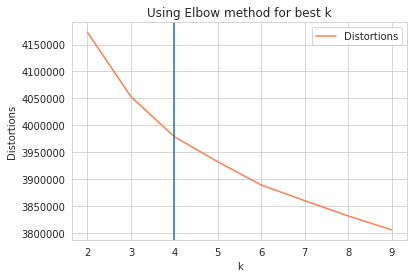

In [16]:
best_kmeans_elbow(features=movies_reviews_embeddings, n_clusters=max_n_cluster, verbose=True)

### Silhouette Method [time consuming]

In [0]:
best_kmeans_silhouette(features=movies_reviews_embeddings, n_clusters=max_n_cluster)

### Best K model

In [0]:
best_k = 2

best_kmeans_labels, _ = kmeans(k=best_k, features=np.array(movies_reviews_embeddings))

### PCA Visualize

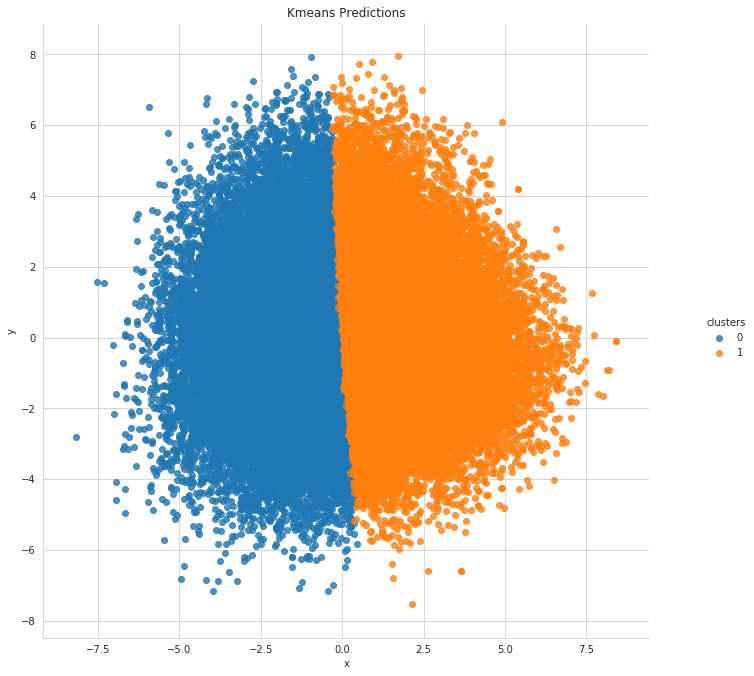

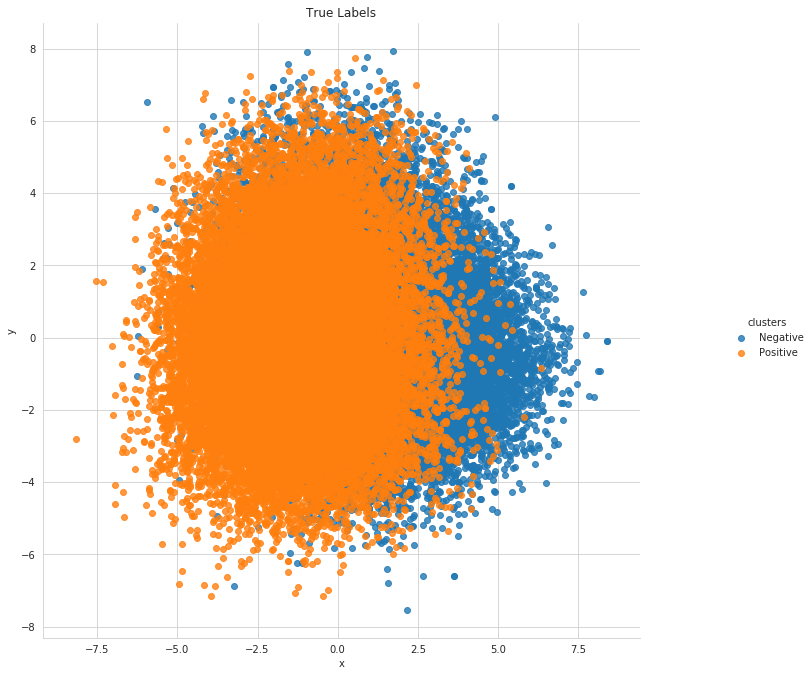



Found labels: [0, 1]



labels                  cluster_match
0  0       Positive:19310  Negative:6693
1  1       Negative:18307  Positive:5690

In [18]:
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

## K Means Sentiments

### k=3 sentiments

In [0]:
k_sentiments = 3

#### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

#### Find Labels

In [21]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



labels                  cluster_match
0  0       Positive:14202  Negative:3847
1  1       Negative:14621  Positive:3302
2  2       Positive:7496  Negative:6532

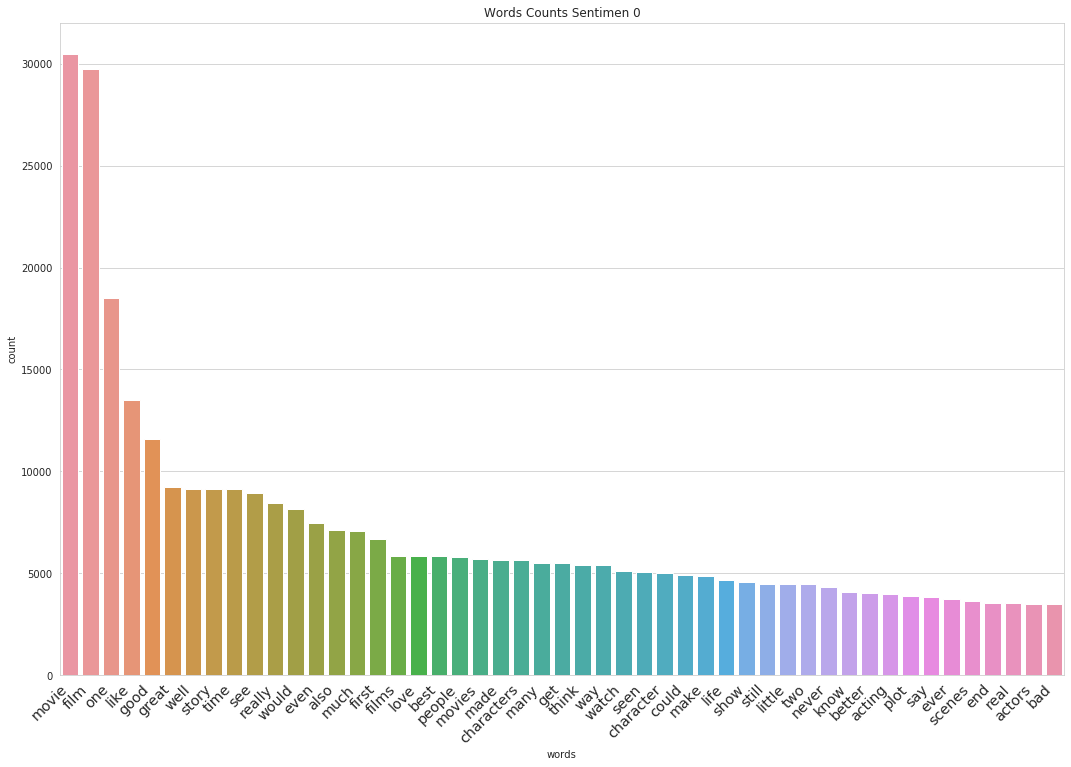

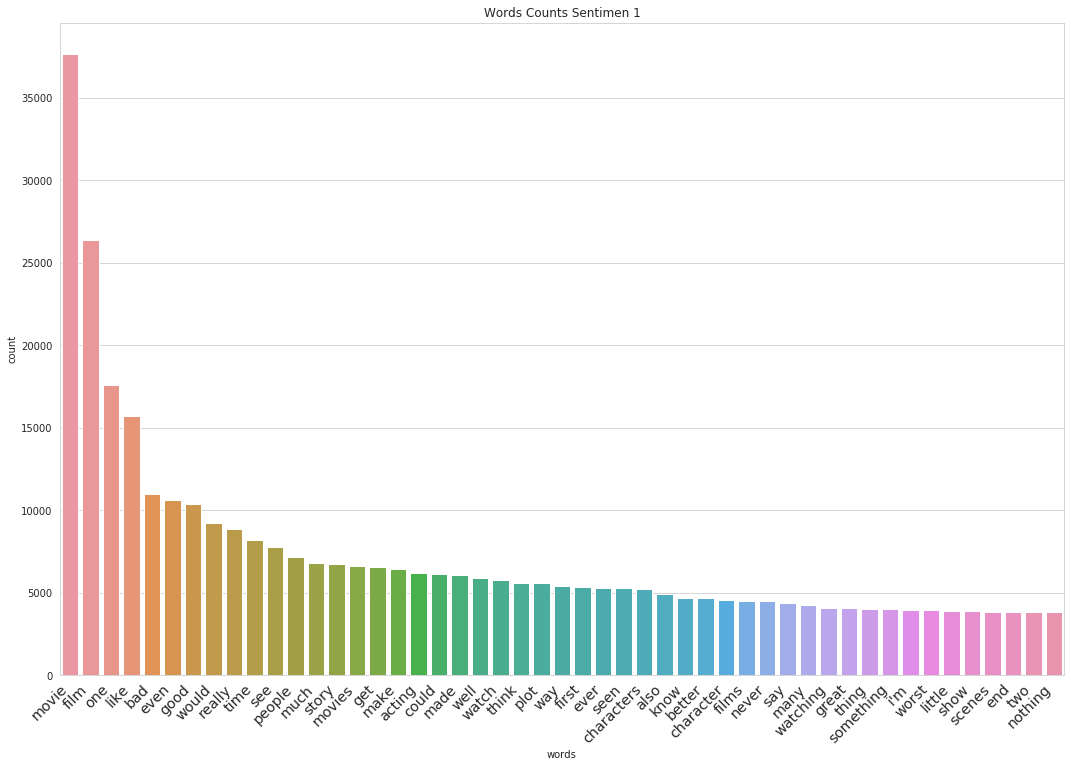

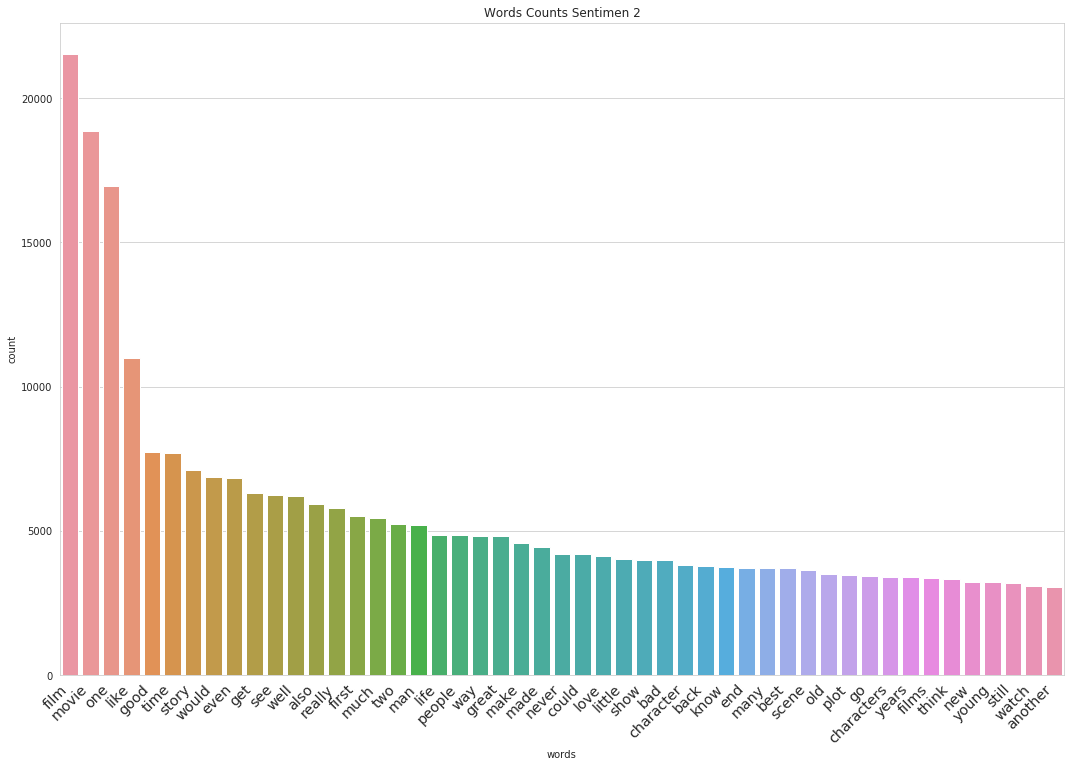

In [22]:
clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

#### Visualize

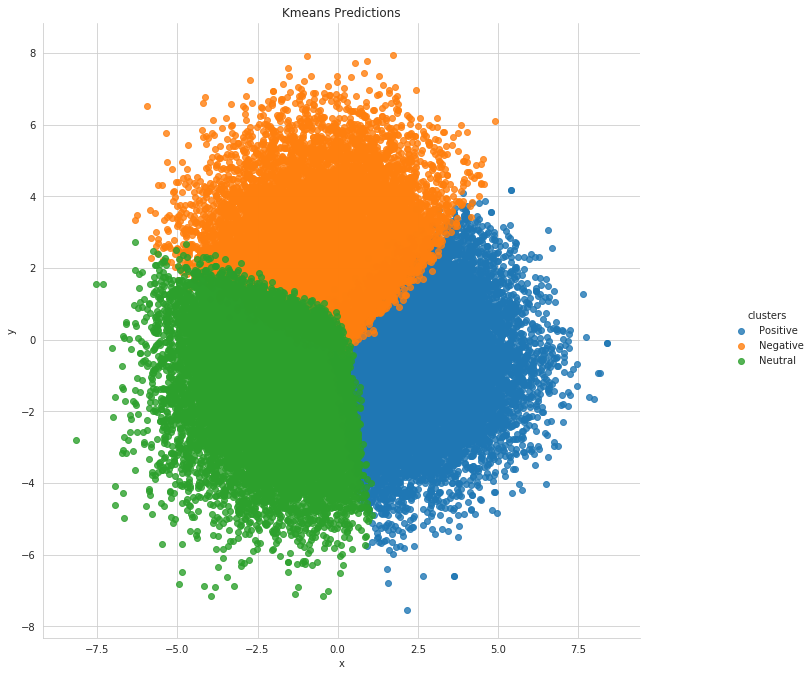

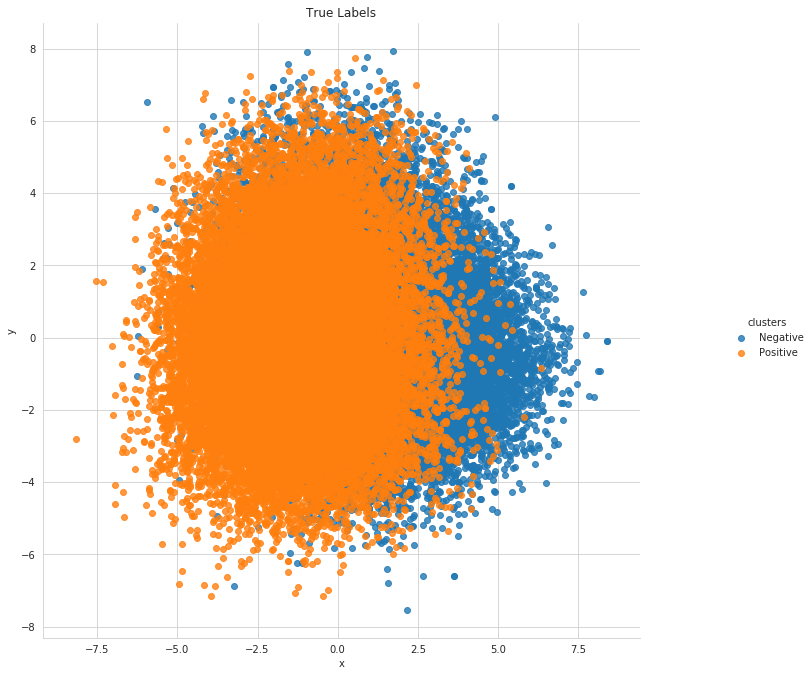

In [23]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


#### Samples

In [24]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=movies_reviews,
                        trues=sentiments_reviews, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  ... Prediction Sentiment
0  I was taken to this film by a friend and was sceptical about a Swedish film with subtitles. However, I thoroughly enjoyed every minute of this beautiful film. The unnecessary cruelty that man is capable of was portrayed confidently without overwhelming images - although animal lovers may have to shield their eyes for a brief couple of seconds somewhere during the first 10 minutes. A traditional story of humility versus brutality and hope versus tragedy was illustrated from a satisfyingly fresh angle using a spectrum of characters with very natural flaws and features. I particularly liked how the film managed to address multiple aspects of hypocritical human behaviour that concern bias, discrimination and sanctimonious pretence. An absolute gem of a film that I will promote to all who will listen.                                                                                                                                                                                                                                                                                                                                                                                                           ...  Neutral            
1  Pokemon 3 is little more than three or four episodes of the TV series, strung together without the usual commercials. The story is typical of Pokemon (conflict, fighting, and a resolution where all are happy in the end), and there is nothing original or unusual in the animation. Some of the holes in the plot are filled in (over the closing credits!) without explanation, and everything is just a bit too sweet.<br /><br />Why see it on the big screen? The only reason is to be a part of your child's world. Both of my sons enjoy Pokemon, and by my showing an interest in what they like, we are closer. Seeing a film in a theatre is still different than seeing it on the tube, and my sons enjoy the full movie-going experience. I gave the movie a 4, mostly from my children's point of view.<br /><br />                                                                                                                                                                                                                                                                                                                                                                                                               ...  Neutral            
2  I thoroughly enjoyed Bilal's graphic novel when it came out, and was amazed when I saw the trailer for this film, and even more so when I found that Bilal had directed it himself. The film, however, was a major letdown. The visuals are nowhere near the rich and gritty texture of the original artworks, and the story is poorly told. Bilal seems to have chosen to focus on the more esoteric aspects of the graphic novel, and he doesn't do a very good job at it, either.<br /><br />The most enjoyable part of the original graphic novel was the friendship-hate relationship between Nikopol and Horus. They were both out of their right time and place, forced together by circumstance. Most of all, they were funny and likable. Not so here. Nikopol has no discernible personality whatsoever, and Horus is a pompous twit who just wants to get laid. Even though the film is French, Horus doesn't have to be!<br /><br />We have all seen films we enjoyed, but wouldn't recommend to everyone, for some reason or other. I wouldn't recommend Immortel to anyone, except maybe as a warning not to overreach your talent and resources. Bilal's a master storyteller, but obviously not a master of every visual medium.  ...  Neutral            

[3 rows x 3 columns]

In [0]:
text_review = samples_df['Text'].values[2]

explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(text_review,  classifier_dn, num_features=MAX_LEN)
exp.show_in_notebook(text=True)

/usr/local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


### k=4 sentiments

In [0]:
k_sentiments = 4

#### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

#### Find Labels

In [27]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



labels                  cluster_match
0  0       Positive:6136  Negative:4364 
1  1       Negative:12584  Positive:2270
2  2       Positive:10913  Negative:2876
3  3       Positive:5681  Negative:5176

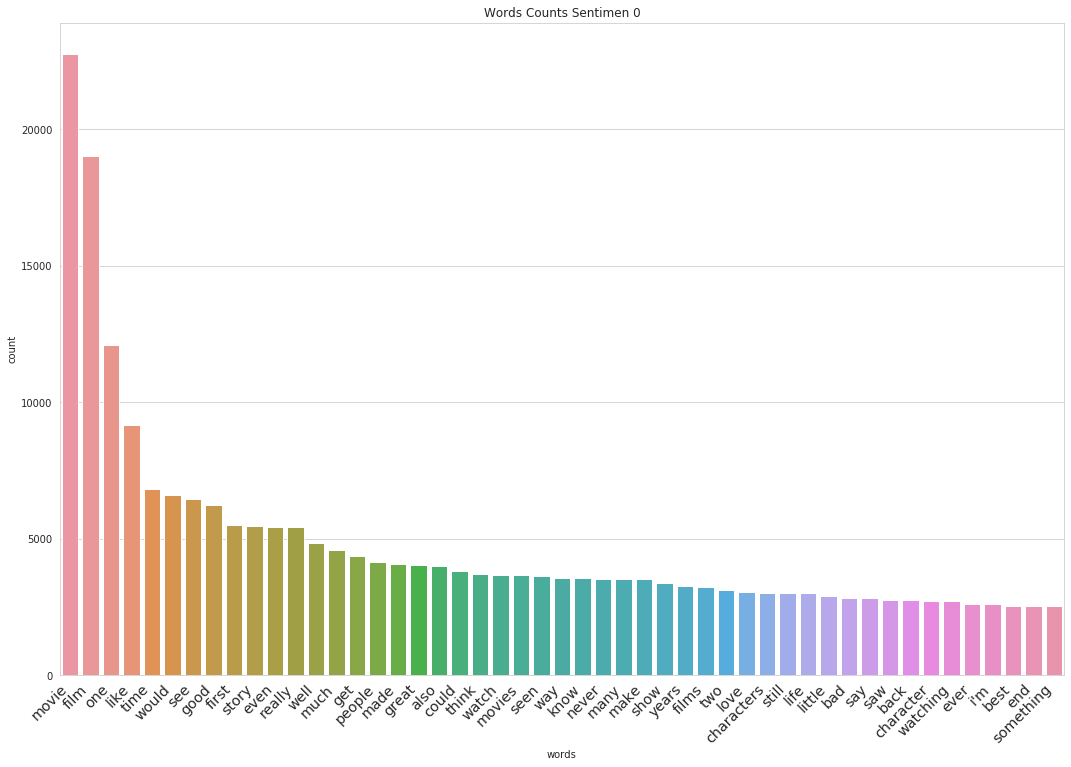

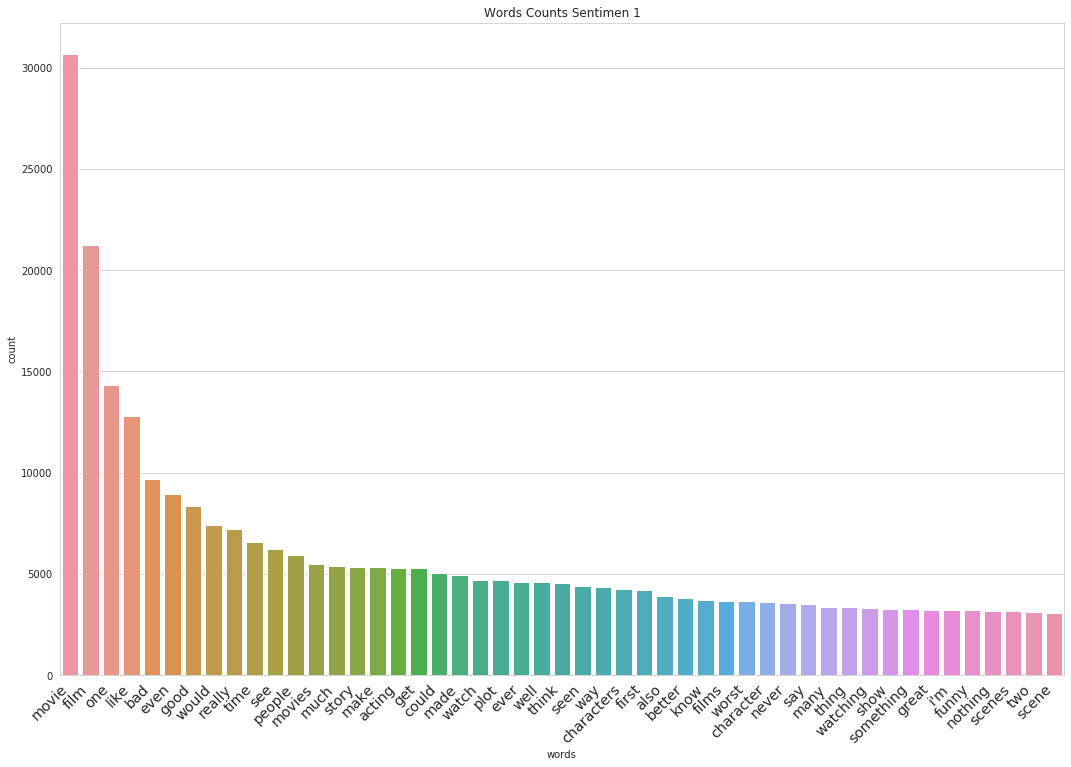

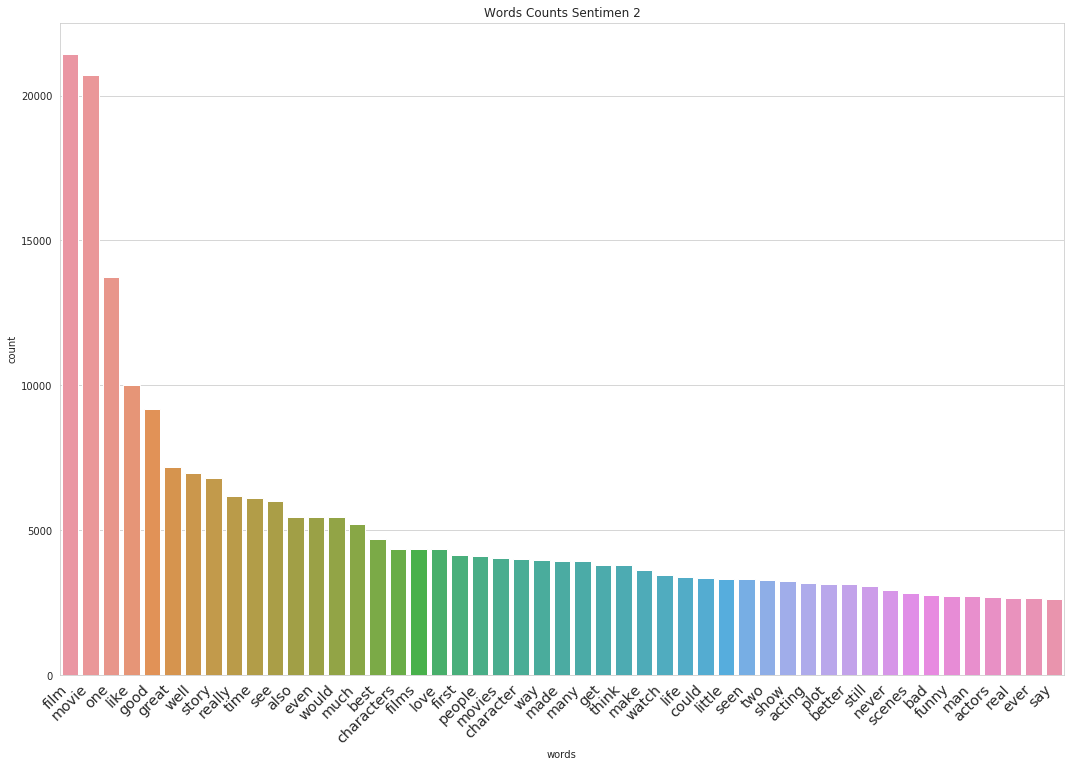

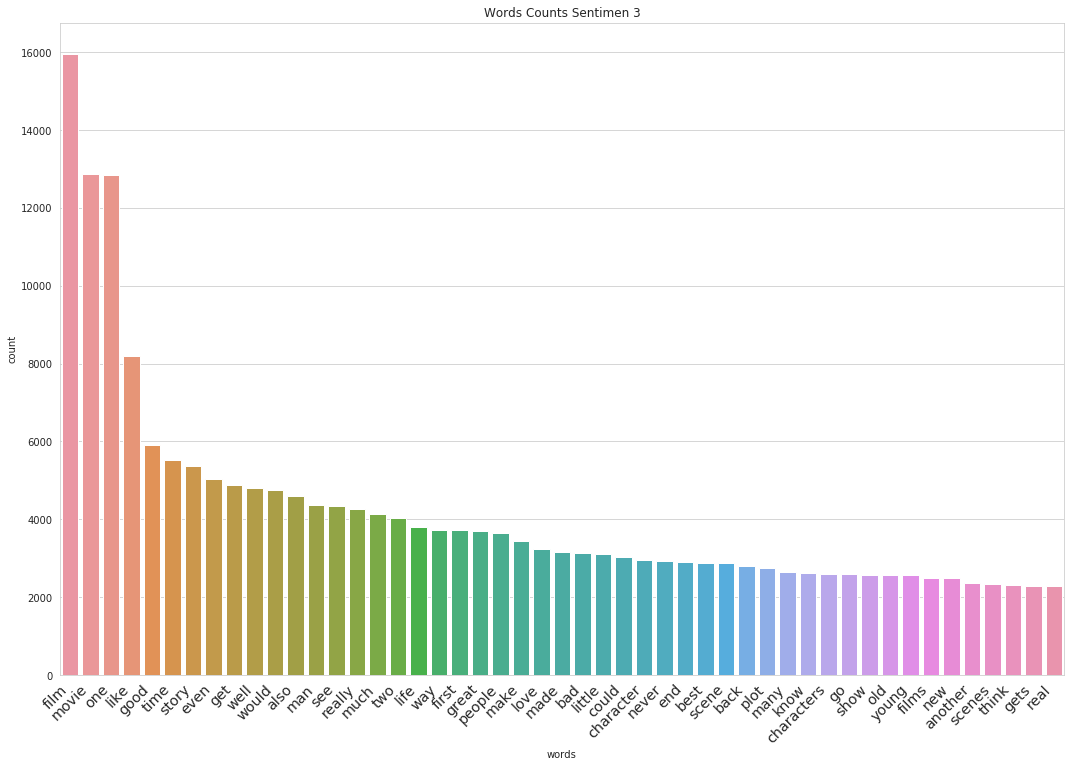

In [28]:
clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

#### Visualize

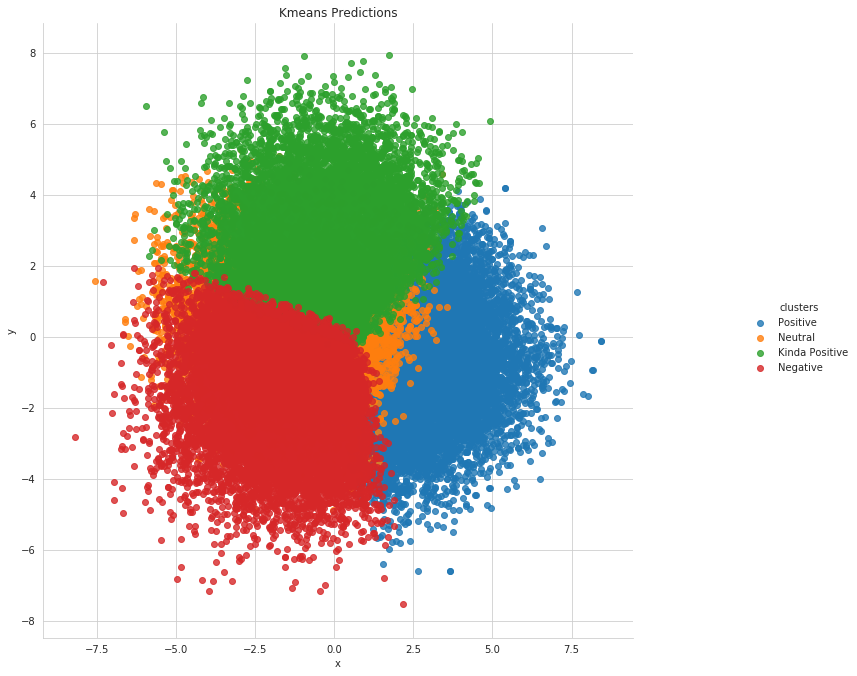

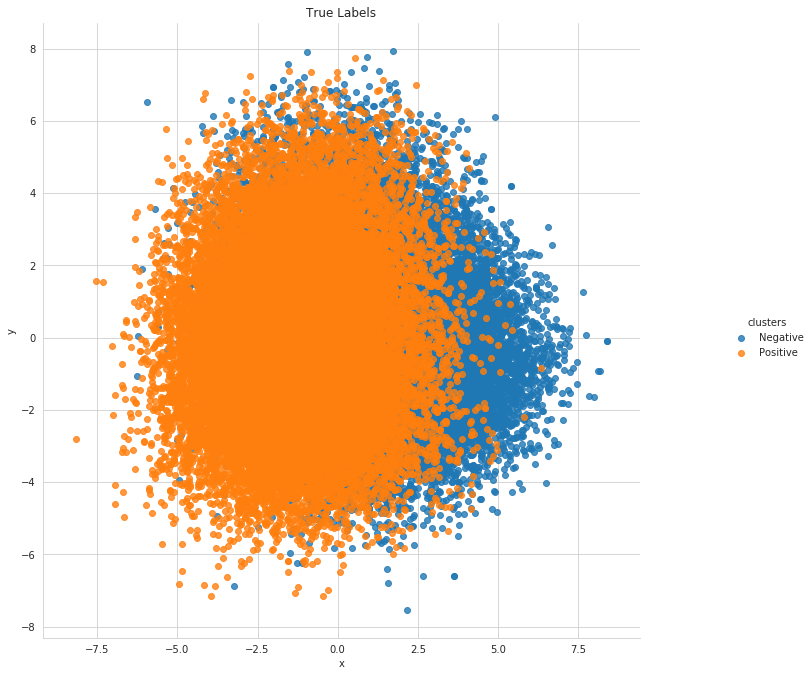

In [29]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


#### Samples

In [30]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=movies_reviews,
                        trues=sentiments_reviews, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  ... Prediction Sentiment
0  "The missing star", who competed for the Golden Lion at 2006 Venice Film Festival, is a film that, when you think about, the first adjective that comes to your mind is: intense. Intense looks, intense sequences, this movie's intensity captures the viewer since the very first scenes at the steelworks, in Italy (I couldn't recognize the city, maybe Genoa or even Naples), although the pace is quite slow.<br /><br />Vincenzo Buonavolontà, the male lead, and with him, all the audience, sees a completely different China than a normal Westerner imagines: horrible high-rise building with about 8 hundred flat owners inside, skyscrapers, desolation, fog, scrapers and cranes everywhere, but also the beauty of the Yangtze Kiang river, that will soon become a big lake because of the controversial dike that will wipe a lot of towns out. China is a country under construction, but, under all these colossal public works, there are still poverty, backwardness and unfair laws.<br /><br />We can relate more easily to this story because Gianni Amelio, the expert director, chose two phenomenal leads: Sergio Castellitto, a well-known actor in Italy, and the Chinese surprise Tai Ling, a total unknown girl that gives an as intense interpretation as Castellitto's.<br /><br />The film is not perfect, there are some flaws here and there, but that doesn't mean it's a mediocre film. Try to see it.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ...  Neutral            
1  Despite this production having received a number of poor reviews, it actually holds up quite well for its age. Note also that it is not a BBC programme, it was simply licensed to them by Granada Ventures when the Jane Austen collection was released on DVD.<br /><br />So how does it compare with other adaptations of the same novel? The most well-known version these days is the 1995 film with Amanda Root as Anne Elliott and Ciaran Hinds as Captain Frederick Wentworth. That film was of course shorter but a good snapshot of the story - the earlier version, with Ann Firbank and Bryan Marshall in the same roles, had four hours to tell the story and moved at a more leisurely pace.<br /><br />Firbank is a good ten years too old for her role, but she is very good - Marshall is excellent as Wentworth, a man disappointed in love, and bitter about interference. And hidden in the cast are people who also

In [0]:
text_review = samples_df['Text'].values[2]

explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(text_review,  classifier_dn, num_features=MAX_LEN)
exp.show_in_notebook(text=True)

/usr/local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


### k=5 sentiments

In [0]:
k_sentiments = 5

#### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

#### Find Labels

In [33]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3, 4]



labels                  cluster_match
0  0       Positive:5002  Negative:3999 
1  1       Negative:11542  Positive:1937
2  2       Positive:9445  Negative:2186 
3  3       Positive:3606  Negative:3495 
4  4       Positive:5010  Negative:3778

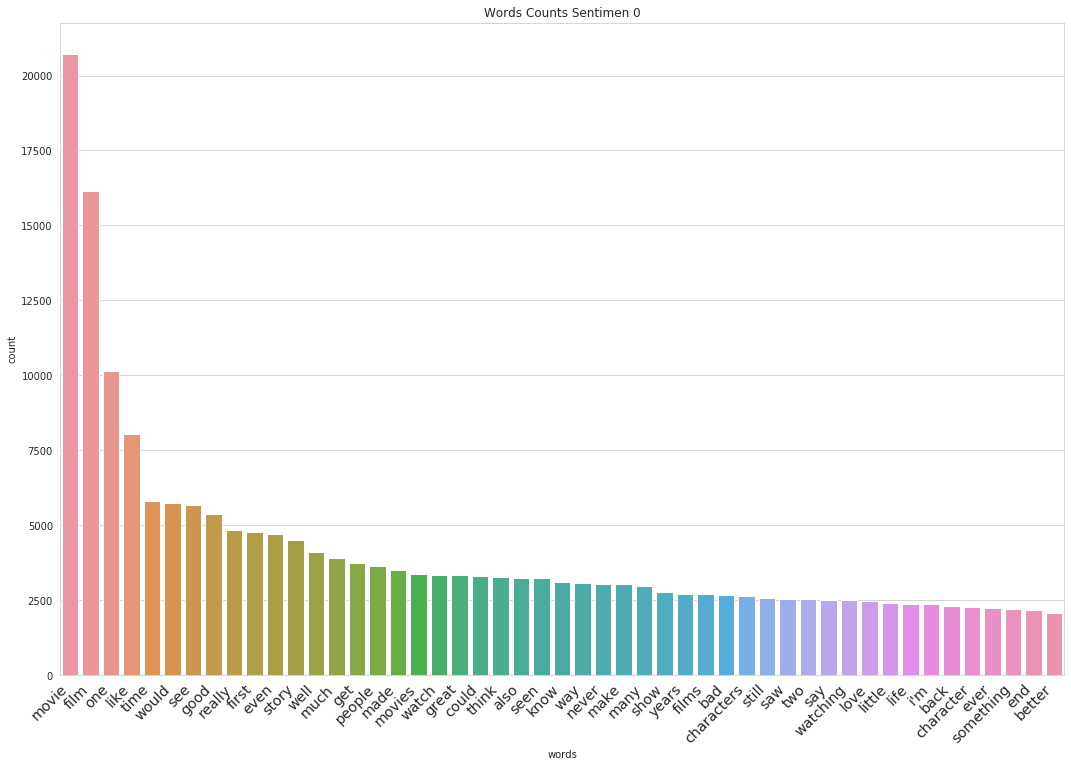

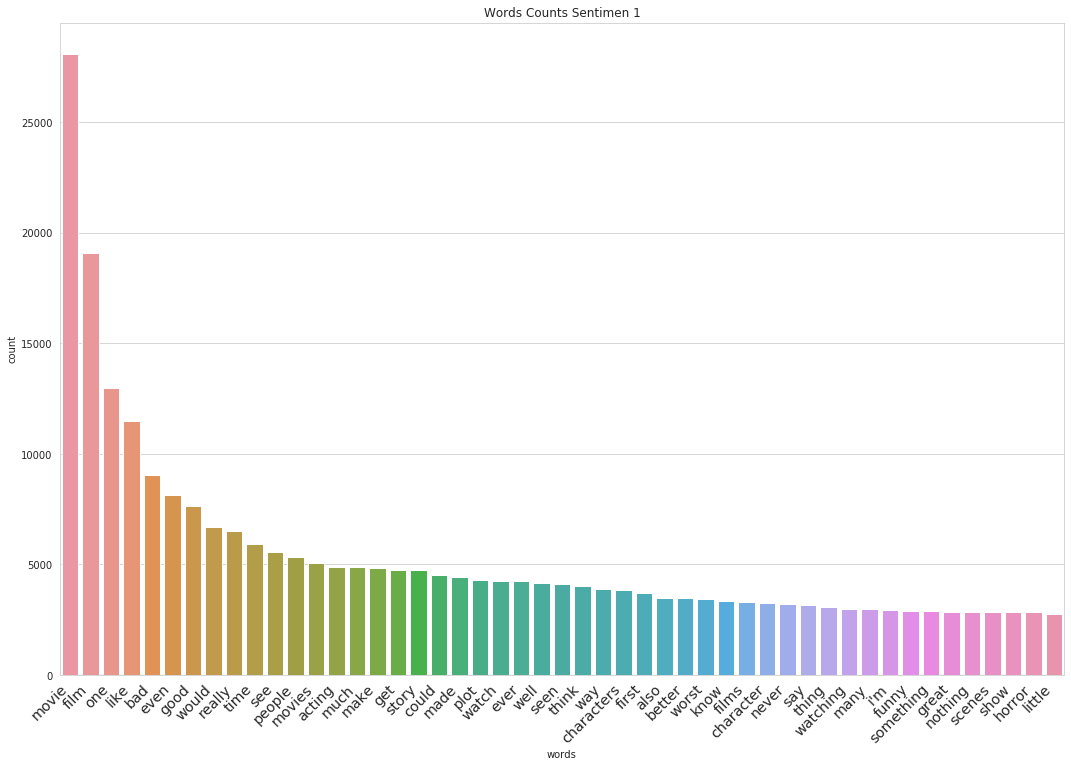

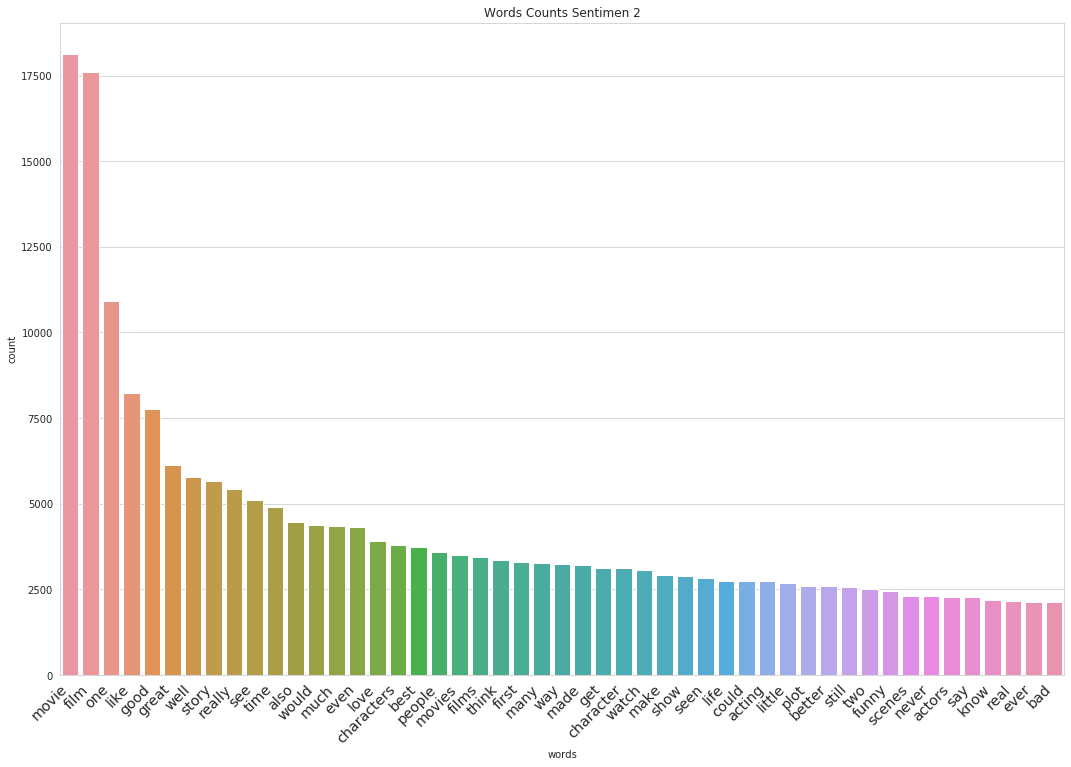

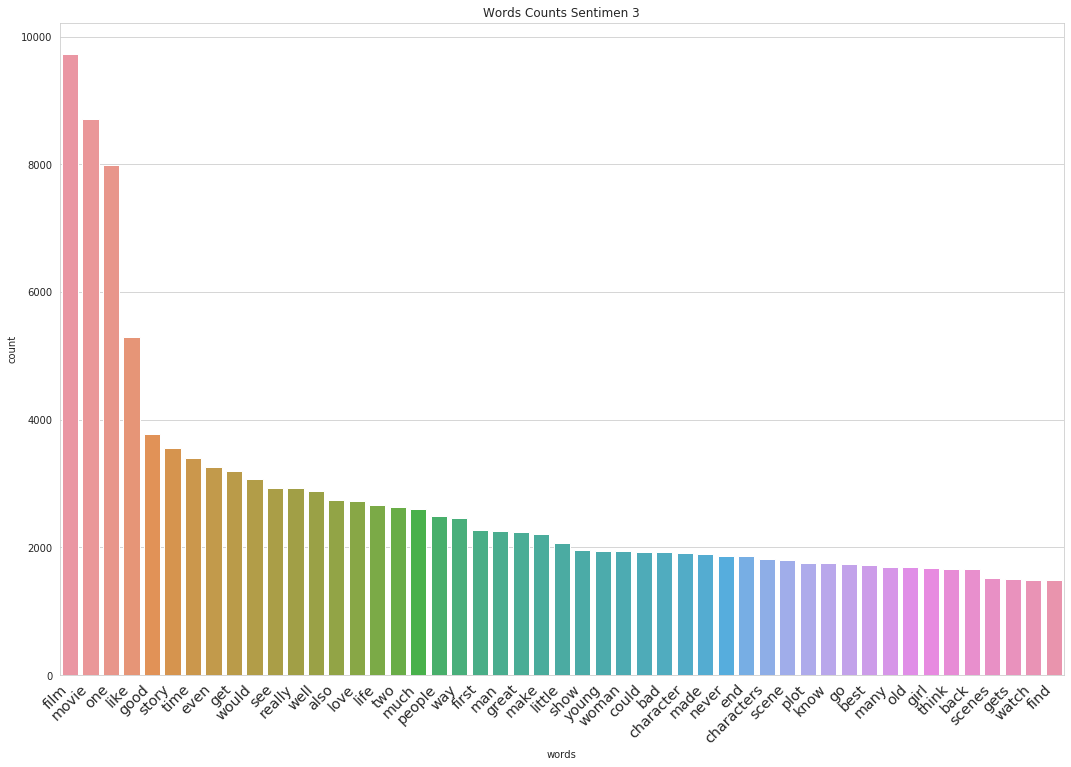

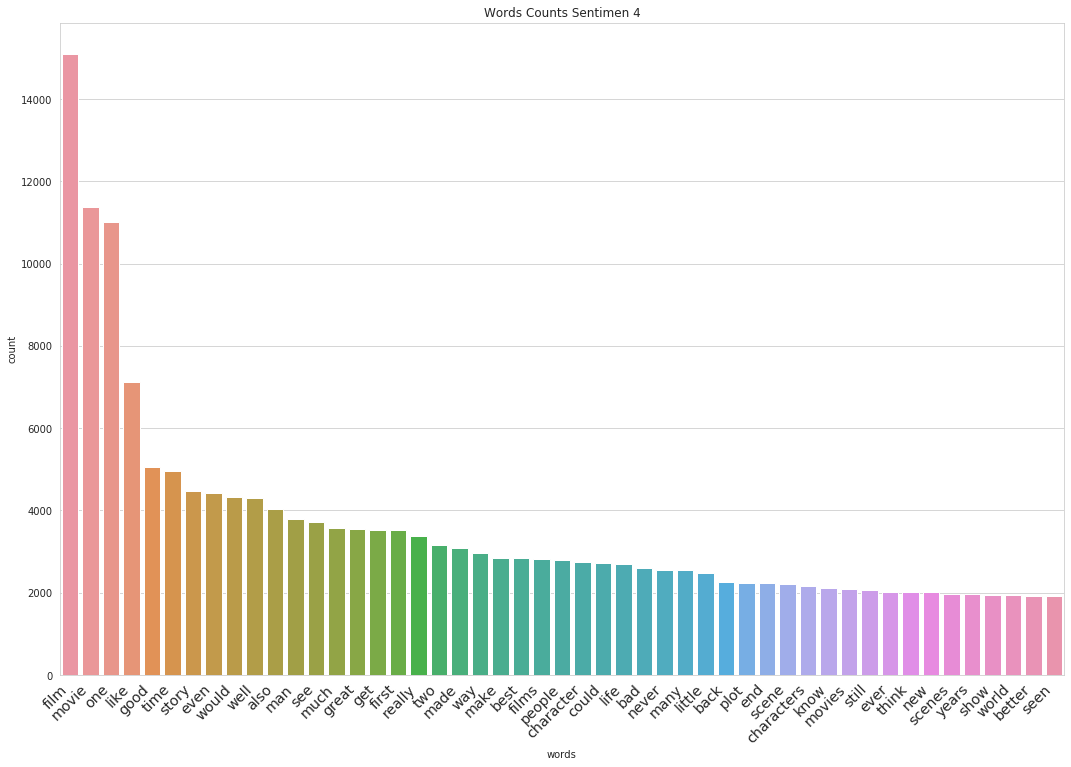

In [34]:
clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

#### Visualize

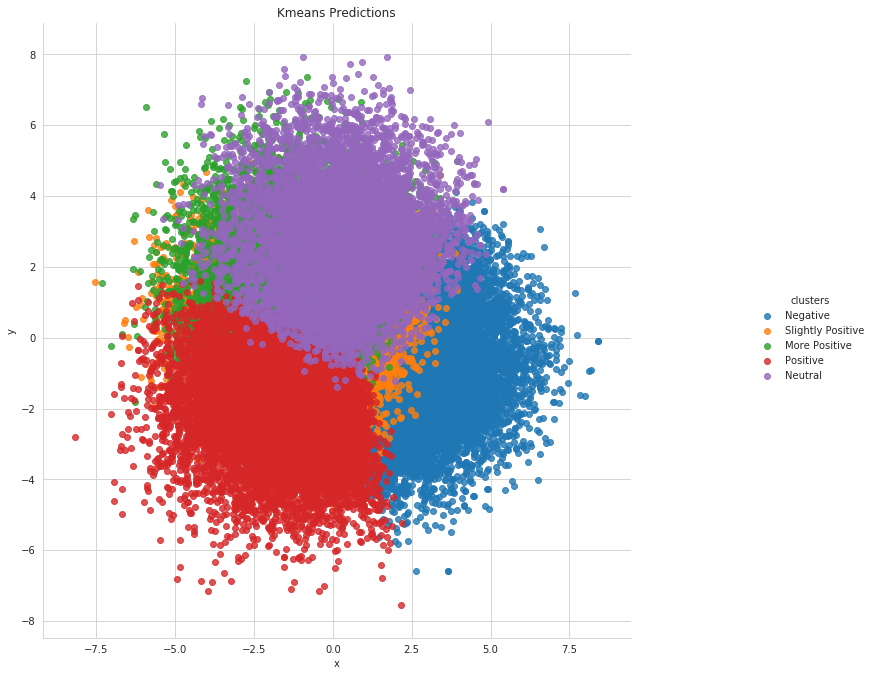

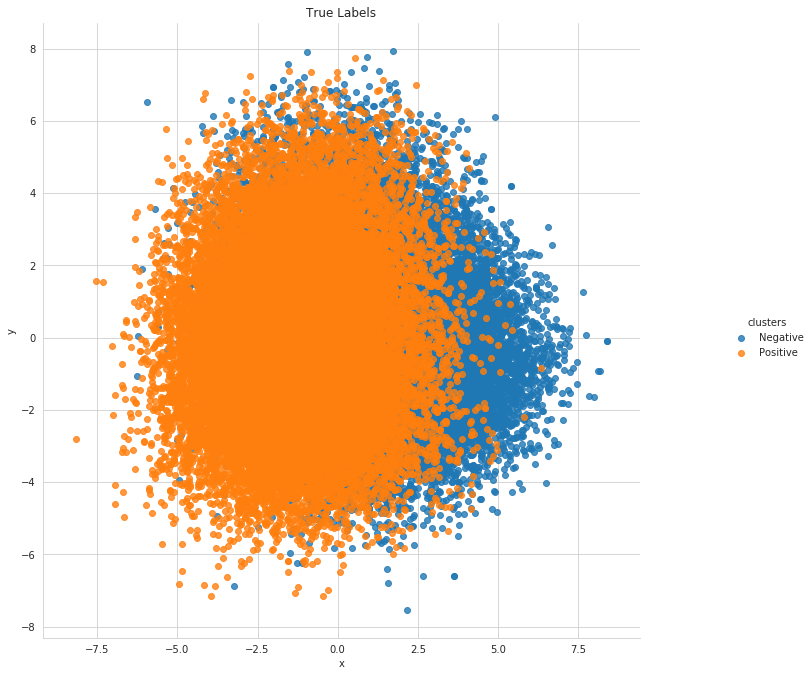

In [35]:
kmeans_id_sentiment = {0:'Slightly Positive',
                        1:'Negative',
                        2:'Positive',
                       3:'Neutral',
                       4:'More Positive'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


#### Samples

In [36]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=movies_reviews,
                        trues=sentiments_reviews, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  ... Prediction Sentiment
0  This comic classic of English school girl antics is and was one of the great art house classics. Then the art house disappeared with the arrival of videos. And so did the audience for this movie. The loss is not to the art houses or to this great film. The loss is to those who will never have a real opportunity to view this memorable laugh filled cinematic masterpiece. But I am preaching to the converted aren't I. Who else would search for this flick?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      ...  Slightly Positive  
1  Am not familiar with the trilogy but came upon this film last night on Showtime. The film looked very well done with the set design and the cinematography, but the screenplay was stilted and wooden. The acting was fairly bad- thought the two female leads were serviceable. You never really believed anything the supporting actors said though. There were the stereotypes- bible-thumping Reverend without a hint of nuance, authoritative Captain, hot-headed soldier, etc. I am sorry to say that based on these deficiencies I clocked it straight away as Canadian without knowing it to be such-the Telefilm Canada end credits gave it away. I know I'm a horrible person.<br /><br />Maybe I missed something in the beginning but the hostility towards the girls is never explained. Here they are besieged in a fort by werewolves and the men are wasting time and energy brutalizing two young women for no reason. FOCUS people. There's a bit more of a pressing situation beyond your walls than whether or not these girls are lesbians-that's just my inference for the hostility directed towards them. If they can aim and fire a gun you might as well make nice with them. The question of their "immortal soul" can be resolved later.<br /><br />Also, I guess this relates to the rest of the trilogy, these girls are supposed to be the protagonists? One of them murdered the Indian guy at the end that saved one of their lives. I guess one is just a victim of her condition who can't be necessarily blamed for her actions, but the other is just a murderer who doesn't deserve her happy ending.  ...  Slightly Positive  
2  I had a lot of hopes for this movie and so watched it with a lot of expectations; basically because of Kamal Hassan. He is an amazing actor who has marked his foot steps in the sands of time forever. But this movie proved to be one of the worst movies i have ever seen. After watching this the movie the brutality and violence in tenebra and clockwork orange looks far better. <br /><br />The Protagonist, Raghavan, is a very daring police officer. Who is assigned to a investigate brutal serial murders. Raghavan efficiently finds the connecting thread in this case and is close to solve the murders and put the psycho killers, two psychologically disturbed but brilliant medical students, behind bars but they escape and again get into a killing 

In [0]:
text_review = samples_df['Text'].values[2]

explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(text_review,  classifier_dn, num_features=MAX_LEN)
exp.show_in_notebook(text=True)

/usr/local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


## Custom Samples

In [37]:
# use last trained model
custom_sample(text="I am meh!", 
              model=kmean_model,
              prediction_id_label=kmeans_id_sentiment)


Batches: 100%|██████████| 1/1 [00:00<00:00, 41.99it/s]

'More Positive'